In [7]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier, plot_importance

In [56]:
train_data = pd.read_csv('./data/train.csv')
train_y = train_data.target
train_x = pd.DataFrame(train_data.drop(["target", "ID_code"], axis=1)).reset_index(drop=True)

In [25]:
test_data = pd.read_csv('./data/test.csv')

In [26]:
sub = pd.read_csv('./data/sample_submission.csv')

In [8]:
summary = train_data.describe()

Text(0.5, 1.0, 'Histogram of all predictors')

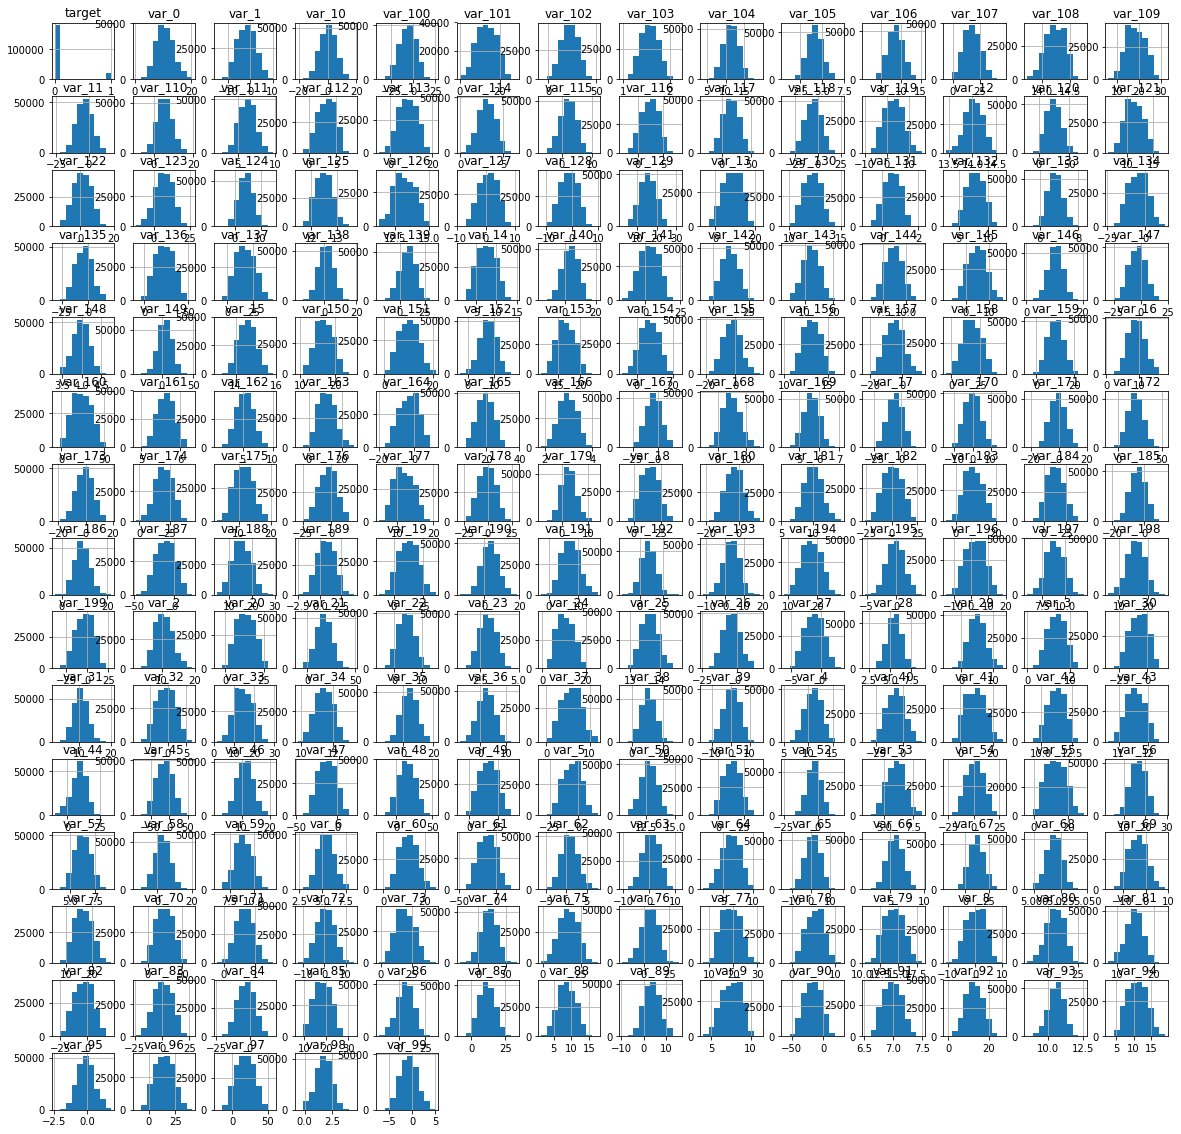

In [12]:
train_data.hist(figsize = (20,20))

plt.tight_layout
plt.title("Histogram of all predictors")

In [ ]:
train_data.isnull().sum().sum()

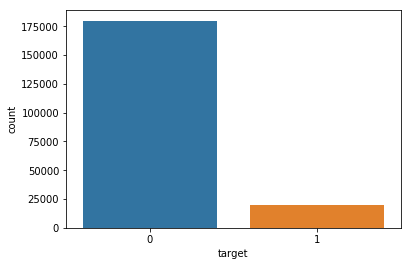

In [119]:
fig = sns.countplot("target", data=train_data)
fig.get_figure().savefig("classImbalance.png")

In [ ]:
summary.columns

In [ ]:
summary.var_0

#### Model Building

I don't think there is any more exploratory needed to be built as the data is normalized to an extent and we can go into the assumption that they are all related.

#### Logistic Regression

In [115]:
logRModel = LogisticRegression(random_state=0).fit(train_x, train_y)

In [116]:
logRModel.score(train_x, train_y)

0.91446

In [117]:
ID_Code = test_data["ID_code"]
test_x = pd.DataFrame(test_data.drop(["ID_code"], axis=1)).reset_index(drop=True)

In [118]:
predictions = logRModel.predict(test_x)

In [ ]:
sub["target"] = predictions
sub.to_csv("logistic_model_predictions.csv", index=False)

#### Result - 0.630 ROC

### Upsampling data

In [102]:
#Install imblearn: conda install -c conda-forge imbalanced-learn 

In [46]:
print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_x, train_y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 20098
Before OverSampling, counts of label '0': 179902 

After OverSampling, the shape of train_X: (359804, 200)
After OverSampling, the shape of train_y: (359804,) 

After OverSampling, counts of label '1': 179902
After OverSampling, counts of label '0': 179902


### Data distribution after up sampling

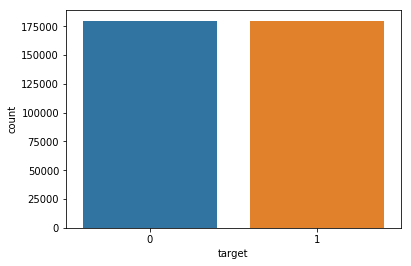

In [101]:
df = pd.DataFrame(y_train_res)
df.columns = ['target']
sns.countplot(x='target', data=df)
plt.show()

### Verifying assumptions for Naive Bayes

In [ ]:
X_train_datadf=pd.DataFrame(X_train_res)

### Likelihood distributions 

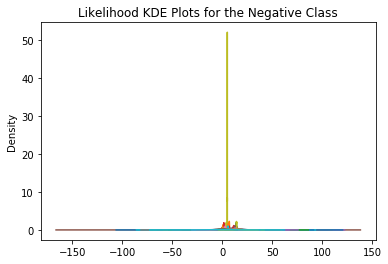

In [112]:
pd.DataFrame(train_x[train_y == 0]).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class');

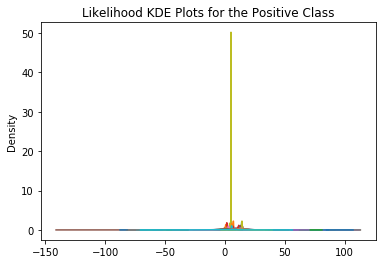

In [109]:
pd.DataFrame(train_x[train_y == 1]).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Positive Class');

### Scaling

In [104]:
scaled = pd.DataFrame(StandardScaler().fit_transform(train_x))

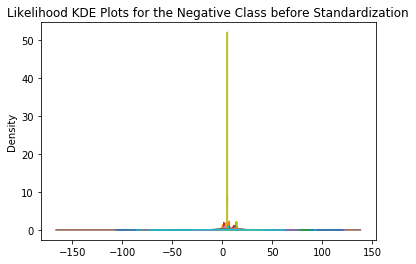

In [151]:
train_x[train_y == 0].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class before Standardization');

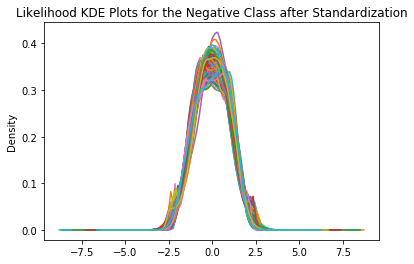

In [108]:
scaled[train_y == 0].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Standardization');

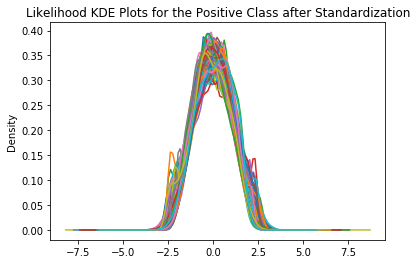

In [110]:
scaled[train_y == 1].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Positive Class after Standardization');

We model the target as unknown  Y  and the features as observation  X . The prior  pY(y)  reflects our knowledge about the unknown before observation. In this problem,  Y  is Bernoulli (only two classes) so it can be specified by setting the positive probability, which is usually set as the proportion of the positive class in the data. The likelihood  fX|Y(x|y)  models the distribution of the observation given that we know the class. The posterior  pY|X(y|x)  is our updated knowledge about the unknown after observation.

The MAP (Maximum A Posteriori) estimator picks the class with the highest posterior probability. For binary classification, it has the same effect as setting a threshold of  0.5  for the positive posterior probability. The LMS (Least Mean Squares) estimator  E[Y|X] picks the mean of the posterior distribution. For binary classification, this is just the positive posterior probability  pY|X(1|x) , which is what we need to submit for the competition.

In [114]:
train_x.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


### Logistic Implementation- with upsampled data - lesser score - 0.778 ROC


In [125]:
logr = LogisticRegression(random_state=0)
logr_model_ud =logr.fit(X_train_datadf, y_train_res)

predictions = logr_model_ud.predict(test_x)
sub["target"] = predictions
sub.to_csv("logistic_ud.csv", index=False)

logRModel.score(train_x, train_y)

NameError: name 'X_train_datadf' is not defined

### LDA Implementation - with upsampled data -  score - 0.778 ROC

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_model_ud = lda.fit(X_train_datadf, y_train_res)
lda_score_ud = lda_model_ud.score(X_train_datadf, y_train_res)
sub["target"] = lda_model_ud.predict(test_x)
sub.to_csv("lda1.csv", index=False)
lda_score_ud

### LDA Implementation -without upsampling - 0.635 ROC

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(train_x, train_y)
lda_score = lda_model.score(train_x, train_y)
sub["target"] = lda_model.predict(test_x)
sub.to_csv("lda.csv", index=False)
lda_score

###  Exploration of Correlation - Features are not correlated

In [120]:
corrs = train_x.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.head(20)

,level_0,level_1,0
39780,var_1,var_80,0.008855
39781,var_80,var_1,0.008855
39782,var_172,var_81,0.008936
39783,var_81,var_172,0.008936
39784,var_122,var_132,0.008956
39785,var_132,var_122,0.008956
39786,var_80,var_6,0.008958
39787,var_6,var_80,0.008958
39788,var_146,var_169,0.009071
39789,var_169,var_146,0.009071


In [121]:
corrs.head(20)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


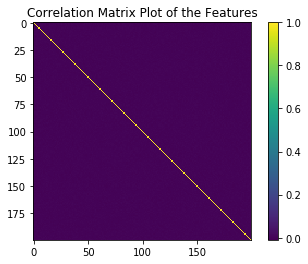

In [123]:
plt.imshow(scaled.corr())
plt.colorbar()
plt.title('Correlation Matrix Plot of the Features');

### QDA Implementation -without upsampling - 0.635 ROC

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(train_x, train_y)
qda_score = qda_model.score(train_x, train_y)
sub["target"] = qda_model.predict(test_x)
sub.to_csv("qda.csv", index=False)
qda_score

### QDA Implementation -with upsampling - 0.514 ROC

In [ ]:
qda_ud = QuadraticDiscriminantAnalysis()
qda_model_ud = qda_ud.fit(X_train_datadf, y_train_res)
qda_score_ud = qda_model_ud.score(X_train_datadf, y_train_res)
sub["target"] = qda_model_ud.predict(test_x)
sub.to_csv("qda1.csv", index=False)
qda_score_ud

In [132]:
gnb = GaussianNB().fit(train_x, train_y)
preds =  gnb.predict_proba(test_x)
gnb.score(train_x, train_y)
sub["target"] = preds
sub.to_csv("gnb.csv", index=False)

In [133]:
gnb.score(train_x, train_y)

0.9217

## Ensemble models

### Ensemble GNB. AUC: 0.888

In [ ]:
prediction = np.zeros(len(test_x))
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
res = dict()
nb_clf = GaussianNB()
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    nb_clf.fit(X_train, y_train)
    col_name = "target_" + str(fold_n)
    preds =  nb_clf.predict_proba(test_x)
    res[col_name] = preds
sub['target']=(res['target_0']+res['target_1']+res['target_2']+res['target_3']+res['target_4'])/5
sub.to_csv("ensemble_gnb.csv", index = False)

fpr, tpr, thr = roc_curve(train_y, sub['target'])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Plot', fontsize=20, y=1.05)
auc(fpr, tpr)

In [ ]:
abc = AdaBoostClassifier(n_estimators=250,learning_rate=0.1)
model = abc.fit(X_train_datadf, y_train_res)
y_pred = model.predict(test_x)
print("Accuracy:",model.score(X_train_datadf, y_train_res)
sub["target"] = y_pred
sub.to_csv("adaboost_us.csv", index=False)

### Ensemble ADA boost: AUC 0.82 

In [21]:
prediction = np.zeros(len(test_x))
n_fold = 6
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
res = dict()
abc = AdaBoostClassifier(n_estimators=250,learning_rate=0.1)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    abc_model = abc.fit(X_train, y_train)
    col_name = "target_" + str(fold_n)
    preds =  abc_model.predict_proba(test_x)
    res[col_name] = preds
    print("Accuracy:",model.score(X_valid, y_valid))
sub['target']=(res['target_0']+res['target_1']+res['target_2']+res['target_3']+res['target_4']+res['target_5'])/6
sub.to_csv("ensemble_ada.csv", index = False)

Fold 0 started at Sat Apr 13 00:03:01 2019
Accuracy: 0.90766
Fold 1 started at Sat Apr 13 00:18:15 2019
Accuracy: 0.90766
Fold 2 started at Sat Apr 13 00:33:29 2019
Accuracy: 0.90766
Fold 3 started at Sat Apr 13 00:48:43 2019
Accuracy: 0.90766
Fold 4 started at Sat Apr 13 01:03:41 2019
Accuracy: 0.90766
Fold 5 started at Sat Apr 13 01:19:07 2019
Accuracy: 0.90766


In [136]:
abc = AdaBoostClassifier(n_estimators=250,learning_rate=0.1)
abc.fit(train_x, train_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=250, random_state=None)

In [139]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(20, 250, 50)}
gsearch1 = GridSearchCV(estimator = AdaBoostClassifier(learning_rate=0.1, random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=10),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 250, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [147]:
gsearch1.best_score_

0.8222018781548233

In [149]:
gsearch1.best_params_

{'n_estimators': 220}

In [150]:
gsearch1.cv_results_

{'mean_fit_time': array([ 109.617553  ,  374.44153385,  637.10841951,  903.10770259,
        1097.05124578]),
 'std_fit_time': array([  1.20945166,   6.76047184,   5.80372624,   5.20950458,
        106.92774479]),
 'mean_score_time': array([0.24227481, 0.6130702 , 0.93771486, 1.33366628, 1.29390335]),
 'std_score_time': array([0.00942777, 0.07632153, 0.04012705, 0.06423772, 0.31234589]),
 'param_n_estimators': masked_array(data=[20, 70, 120, 170, 220],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20},
  {'n_estimators': 70},
  {'n_estimators': 120},
  {'n_estimators': 170},
  {'n_estimators': 220}],
 'split0_test_score': array([0.68147818, 0.75862648, 0.78885803, 0.80448224, 0.81866355]),
 'split1_test_score': array([0.67600672, 0.75402751, 0.78566536, 0.80334218, 0.81769893]),
 'split2_test_score': array([0.68412467, 0.75775253, 0.78978013, 0.80946853, 0.82281103]),
 'split3_test_score': array(

### XG Boost

In [7]:
model = XGBClassifier()
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

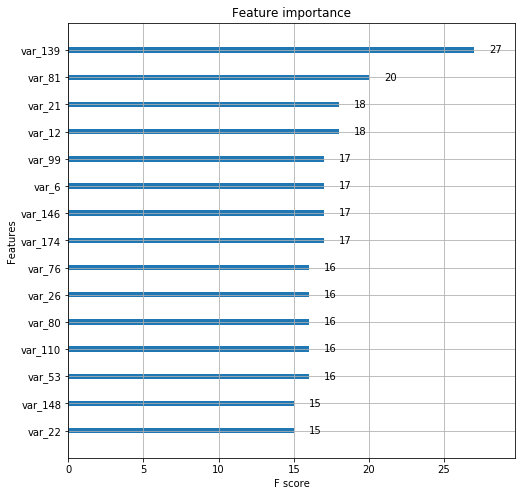

In [20]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
fig, ax = plt.subplots(1,1,figsize=(8,8)) 
plot_importance(model, max_num_features = 15, ax=ax )
plt.show()

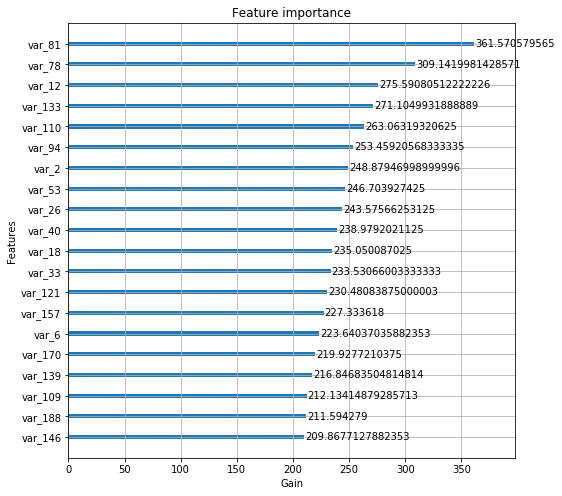

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,8)) 
xgb.plot_importance(model, max_num_features=20, ax=ax, importance_type="gain", xlabel="Gain")
plt.show()

### AUC 0.87528 (params) and AUC 0.89881(params2)

In [42]:
params_2 = {
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.093,
    'max_depth': 2,
    'colsample_bytree': 0.356,
    'subsample': 0.824,
    'min_child_weight': 53,
    'gamma': 9.94,
    'silent': 1
}

params = {
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 2,
    'colsample_bytree': 0.35,
    'subsample': 0.82,
    'min_child_weight': 50,
    'gamma': 10,
    'silent': 1
         }

### Using upsampled data

In [82]:
prediction = np.zeros(len(test_x))
n_fold = 2
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=7)
res = dict()  
train_x_ud = pd.DataFrame(X_train_res)
train_y_ud = pd.DataFrame(y_train_res)
train_x_ud.columns = train_x.columns
train_y_ud.columns = ['target']
train_y_ud = train_y_ud.target
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x_ud, train_y_ud)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train_x_ud.loc[train_index], train_x_ud.loc[valid_index]
    y_train, y_valid = train_y_ud.loc[train_index], train_y_ud.loc[valid_index]
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
    dval = xgb.DMatrix(X_valid, y_valid, feature_names=X_valid.columns)  
    clf = xgb.train(params=params_2, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
    prediction += clf.predict(xgb.DMatrix(test_x)) / folds.n_splits
sub['target']=prediction
sub.to_csv("ensemble_xgboost_3.csv", index = False)

Fold 0 started at Sat Apr 13 07:28:17 2019
[07:28:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	Train-auc:0.575524	Val-auc:0.572257
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.896452	Val-auc:0.890041
[200]	Train-auc:0.921821	Val-auc:0.915759
[300]	Train-auc:0.932193	Val-auc:0.925998
[400]	Train-auc:0.938365	Val-auc:0.93189
[500]	Train-auc:0.942921	Val-auc:0.93612
[600]	Train-auc:0.946448	Val-auc:0.939419
[700]	Train-auc:0.949392	Val-auc:0.942171
[800]	Train-auc:0.951695	Val-auc:0.944133
[900]	Train-auc:0.953673	Val-auc:0.945922
[1000]	Train-auc:0.955347	Val-auc:0.947426
[1100]	Train-auc:0.956866	Val-auc:0.948742
[1200]	Train-auc:0.958221	Val-auc:0.949888
[1300]	Train-auc:0.959402	Val-auc:0.9509
[1400]	Train-auc:0.960423	Val-auc:0.951773
[1500]	Train-auc:0.961318	Val-auc:0.9525
[1600]	Train-auc:0.962187	Val-auc:0.953165
[1700]	

In [5]:
tdata = pd.read_csv('./data/newcolumns_17.csv', encoding = "ISO-8859-1")

In [15]:
pd.get_dummies(tdata)

,EMPLOYER_NUM_EMPLOYEES,EMPLOYER_YR_ESTAB,JOB_INFO_TRAINING_NUM_MONTHS,JOB_INFO_EXPERIENCE_NUM_MONTHS,JOB_INFO_ALT_CMB_ED_OTH_YRS,JOB_INFO_ALT_OCC_NUM_MONTHS,FW_INFO_YR_REL_EDU_COMPLETED,PW_SOC_TWO_DIGIT,NAICS_US_TWO_DIGIT,APP_DATE_DIFF,...,NAICS_US_TWO_TITLE_Manufacturing,"NAICS_US_TWO_TITLE_Mining, Quarrying, and Oil and Gas Extraction",NAICS_US_TWO_TITLE_Other Services (except Public Administration),"NAICS_US_TWO_TITLE_Professional, Scientific, and Technical Services",NAICS_US_TWO_TITLE_Public Administration,NAICS_US_TWO_TITLE_Real Estate and Rental and Leasing,NAICS_US_TWO_TITLE_Retail Trade,NAICS_US_TWO_TITLE_Transportation and Warehousing,NAICS_US_TWO_TITLE_Utilities,NAICS_US_TWO_TITLE_Wholesale Trade
0,27.0,2000.0,NaN,36.0,NaN,NaN,NaN,43.0,23.0,7,...,0,0,0,0,0,0,0,0,0,0
1,156.0,2002.0,NaN,120.0,NaN,NaN,2008.0,15.0,54.0,8,...,0,0,0,1,0,0,0,0,0,0
2,89.0,2009.0,NaN,36.0,NaN,NaN,2012.0,11.0,51.0,8,...,0,0,0,0,0,0,0,0,0,0
3,8.0,1997.0,NaN,NaN,NaN,NaN,2014.0,13.0,54.0,8,...,0,0,0,1,0,0,0,0,0,0
4,5.0,2005.0,NaN,24.0,NaN,NaN,NaN,35.0,72.0,8,...,0,0,0,0,0,0,0,0,0,0
5,2459.0,1966.0,NaN,120.0,NaN,120.0,2004.0,27.0,54.0,8,...,0,0,0,1,0,0,0,0,0,0
6,390.0,1987.0,NaN,24.0,NaN,NaN,NaN,47.0,54.0,4,...,0,0,0,1,0,0,0,0,0,0
7,37.0,2012.0,NaN,60.0,1.0,60.0,2007.0,15.0,54.0,7,...,0,0,0,1,0,0,0,0,0,0
8,79.0,2011.0,NaN,12.0,NaN,12.0,2013.0,15.0,54.0,8,...,0,0,0,1,0,0,0,0,0,0
9,222.0,1977.0,NaN,NaN,NaN,NaN,1996.0,15.0,51.0,8,...,0,0,0,0,0,0,0,0,0,0


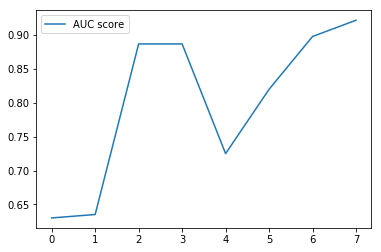

In [10]:
import pandas as pd 
  
# initialize list of lists 
data = [['Logistic Regression', 0.63], ['LDA', 0.635], ['Naive Bayes', 0.887],['Ensemble method (GNB)', 0.887],
        ['Neural Network', 0.725], ['Ada Boost', 0.82],['XGBoost', 0.898], ['LGBM', 0.922]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Machine learning methods', 'AUC score']) 
  
# print dataframe. 
df.plot.line()
plt.show()

In [23]:
df[0:]

,Machine learning methods,AUC score
0,Logistic Regression,0.630
1,LDA,0.635
2,Naive Bayes,0.887
3,Ensemble method (GNB),0.887
4,Neural Network,0.725
5,Ada Boost,0.820
6,XGBoost,0.898
7,LGBM,0.922
